## Impulse Control Algorithm for HFT Market Making

For my homie Pontus <3

### Algorithmic design
The algorithm seeks to optimize the bid ask spread + hedging decisions for each time $t<T$ such that the net Profit and Loss of trading the spread is maximized at the end of the trading session time $T$. We also want to control the algorithm for excessive risk taking during the trading session. Thus, we impose two penalties: (1) running inventory penalty for trading too large exposures during the trading session, and (2) terminal inventory penalty i.e. holding non-zero inventory at the end of the trading day.  Mathematically, the maximization of stochastic system subject to the penalties is equivalent to maximizing the following:

\begin{align}
    V(t, X_t, q_t, S_t) = \underset{\delta^b, \delta^a}{max} \ \mathbb{E} \left( X_T + q_T(S_T - \alpha q_T) - \phi\int_{t}^{T}q_s^2 ds - \sum_{\tau < T}\xi_{\tau}\right)
\end{align}

where

- $X_t$ is the market maker's cash at time $t$
- $q_t$ is the market maker's inventory at time $t$
- $S_t$ is the mid-price of the asset at time $t$
- $\xi_{\tau}$ is average cost of crossing one contract at (stopping) time $\tau$
- $\alpha > 0$ is terminal inventory penalty parameter
- $\phi > 0$ is running inventory penalty parameter

### Solving the control problem (HJB-QVI)
The problem above may be solved as a HJB-QVI problem where we decide between (1) market making, (2) sending market order to buy one contract or (3) sending market order to sell one contract. Applying standard Dynamic Programming Principle to $V(t, X_t, q_T, S_t)$ tells us that $V$ must satisfy the following HJB-QVI:

\begin{align}
   0 =  max \left( \frac{\partial V}{\partial t} + \underset{\delta^b, \delta^a}{max} \left[ \mathcal{L}V(t) -\phi q_t^2 \right] ; \mathcal{S}V-V;\mathcal{B}V-V\right)
\end{align}

where the operators $\mathcal{S}$ and $\mathcal{B}$ act on $V(t, X_t, q_T, S_t)$ such that

\begin{align}
    \mathcal{S}V(t) &= V(t, X_t - \xi, q_T - 1, S_t) \\
    \mathcal{B}V(t) &= V(t, X_t - \xi, q_T + 1, S_t)
\end{align}
In other words, they represent (in abstract sense) the cost of crossing the spread.

### Numerical computation
The problem with the above HJB-QVI is that it is difficult (for me the author at least hehe...hmm) to find a closed form solution. This is not a problem, if we are willing to get our hands dirty (read: use numerical schemes!). Consequently, we will use a hammer called finite differences to nail the problem down. We first solve the HJB part as if there was no QVI conditions at all. Then, after we have obtained HJB PDE solution we look the grid again and satisfy the QVIs.

So, looking at the HJB part 

\begin{align}
   \frac{\partial V}{\partial t} + \underset{\delta^b, \delta^a}{max} \left[ \mathcal{L}V(t) -\phi q_t^2 \right] 
\end{align}

we see that the time derivative may be discretized using a backward Euler finite difference scheme. Then solving for 
$V(t-dt)$ yields:

\begin{align}
    V(t_{i-1}) = V(t_{i})\Delta t + \underset{\delta^b, \delta^a}{max} \left[ \mathcal{L}V(t_{i}) -\phi q_t^2 \right] \Delta t
\end{align}

After we have computed $V(t_{i})$ for each $i = 0, 1, ..., N$ over the inventory time grid $(t,q)$ we solve the QVI part by taking maximums between the three options:

\begin{align}
    V(t, X_t, q_t, S_t) = max \{ V(t_{i}); \mathcal{S}V(t_{i}) ;\mathcal{B}V(t_{i}) \}
\end{align}

Finally, we need to assume some functional form (educated guess!) for the function $V$. To make our life easy, we use the following linear form which is quite common in the literature:

\begin{align}
    V(t, X_t, q_t, S_t) &= X_t + q_t(S_t - \alpha q_t) + v(t, q_t) \\
    v(T, q_T) &= -\alpha q_T^2
\end{align}


### Numerical examples

Let us consider in which kind of behavior the model would result if we programmed a computer to implement it. In the following we will solve the model for 5 minute trading period. We would then repeat the 5 minute cycle until the end of the trading horizon.

In [27]:
import numpy as np
import matplotlib.pyplot as pp;

from src.hjb_solvers import (
    MM_Model_Parameters,
    AS3P_Finite_Difference_Solver,
)


#### Model parameters:
Below we have assumed some set of parameters. In real life you need to do some data science hocus pocus to come up with $\mathbb{P}$-measured set of parameters for the model. For the decay parameter $\kappa$ the reader is adviced to refer the original paper by Avellaneda and Stoikov (2008).

In [28]:

lambda_m = 50  # Number of market order arrivals per minute on the bid
lambda_p = 50  # Number of market order arrivals per minute on the ask
kappa_m = 100  # Decay parameter for "fill rate" on the bid
kappa_p = 100  # Decay parameter for "fill rate" on the ask
delta = 0
phi = 0.000001 # running inventory penalty parameter (try changing me!)
alpha = 0.0001 # terminal inventory penalty parameter (try changing me!)
q_min = -25    # largest allowed short position
q_max = 25     # largest allowed long position
cost = 0.001   # trading cost per market order
rebate = 0.01

# We solve the model for 5 minute chunks. T
T = 5 # minutes
n = 5*60 # one step per second

In [29]:
parameters = MM_Model_Parameters(lambda_m, lambda_p ,kappa_m, kappa_p, delta,
                                   phi, alpha, q_min, q_max, T, cost, rebate)
    
impulses, model = AS3P_Finite_Difference_Solver.solve(parameters, N_steps=n)

### Value function $v$

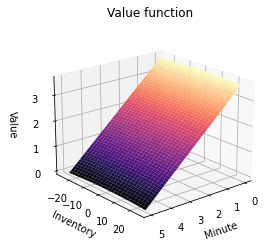

In [30]:
# Plot the value function
Y = model.q_grid
X = model.t_grid
X, Y = np.meshgrid(X,Y)
f = pp.figure(figsize=[5, 4]);
pp3d = pp.axes(projection="3d", elev=20, azim=50);
pp3d.set_title("Value function");
pp3d.set_xlabel("Minute");
pp3d.set_ylabel("Inventory");
pp3d.set_zlabel("Value");
pp3d.plot_surface(X, Y, model.h, cmap='magma');

### Impulse regions i.e. when do we send market orders??

Text(0.5, 0, 'Second')

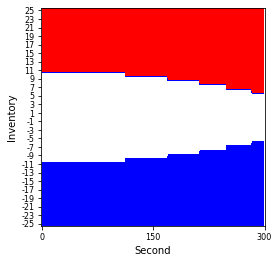

In [31]:
 # Plot the impulse regions
from matplotlib import colors
import matplotlib.patches as mpatches
mycolors = ['white', 'blue', 'red']
cmap = colors.ListedColormap(mycolors)
f, ax = pp.subplots(figsize=[4, 4])
ax.imshow(impulses, cmap=cmap, aspect='auto')
ax.set_xticks([0, 0.5*n, n])
ax.set_xticklabels([0, int(0.5*n), n],fontsize=8);
ax.set_yticks(np.arange(0, len(model.q_grid), 2));
ax.set_yticklabels(model.q_grid[::2],fontsize=8);
ax.set_ylabel('Inventory')
ax.set_xlabel('Second')

In the above graph the red region is where we "hedge" by sending sell market orders while blue region is where we send buy market orders.

### How do we market make then?

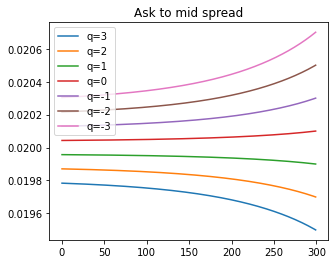

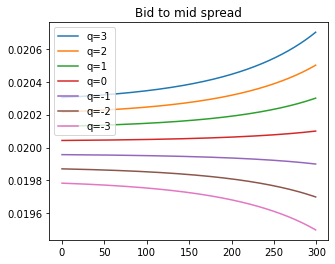

In [26]:
# Plot the ask spread for continuation region
f, ax = pp.subplots(figsize=[5, 4])
for q in range(3, -4, -1):
    ax.plot(model.l_p[q], label=f'q={q}')
ax.set_title("Ask to mid spread")
pp.legend()

# Plot the bid spread for continuation region
fig, ax = pp.subplots(figsize=[5, 4])
for q in range(3, -4, -1):
    ax.plot(model.l_m[q], label=f'q={q}')
ax.set_title("Bid to mid spread")
pp.legend()
    
    